In [1]:
from numpy import *
import MDAnalysis as mda
import MDAnalysis.analysis.distances
from pylab import *
style.use('seaborn-poster')
import glob
import scipy.stats

In [2]:
EQPOINT=250


h2opath="data/water/solvent_included/"
pegpath="data/peg/solvent_included/"

#glob tprs
h2ogros=glob.glob(h2opath+"*.gro")
peggros=glob.glob(pegpath+"*.gro")

#glob tprs
h2otprs=glob.glob(h2opath+"*.tpr")
pegtprs=glob.glob(pegpath+"*.tpr")

#trjs
h2otrjs=glob.glob(h2opath+"*.xtc")
pegtrjs=glob.glob(pegpath+"*.xtc")

systemtprs=[h2otprs,pegtprs]
systemtrjs=[h2otrjs,pegtrjs]



resids_proper=list(arange(-4,67))+list(arange(69,238))
resids=list(arange(-4,67))+[nan,nan]+list(arange(69,238))#get universes 
h2ou=[]
pegu=[]

for i in range(len(h2ogros)):
    h2ou.append(mda.Universe(h2otprs[i],h2otrjs[i]))
    #fix resids immediately
    h2ou[i].select_atoms("protein or resname CH6").residues.resids = resids_proper
for i in range(len(peggros)):
    pegu.append(mda.Universe(pegtprs[i],pegtrjs[i]))
    #fix resids immediately
    pegu[i].select_atoms("protein or resname CH6").residues.resids = resids_proper
    
    
#compile all the systems in one list
systems = [h2ou,pegu]
system_names = ['No-PEG','PEG']
#[]
#[tol-darkgreen,tol-darkblue,tol-bottompurple]
twoColour=["#0A732D","#332288"]
# Dark green,    
#sixColor=['#0A732D','#332288','#88CCEE',"#44AA99",'#882255','#D250BC']
#colorScheme=sixColor
colourScheme = twoColour
# Let's set up the selections for each trajectory by chain

# i want to make a list that has the sh2 domains selected in each sublist so that each one has 6 selections.
h2ou_fullprotein=[]
pegu_fullprotein=[]

h2ou_fullprotein_string=[]
pegu_fullprotein_string=[]


h2ou_notail=[]
pegu_notail=[]


h2ou_notail_string=[]
pegu_notail_string=[]


for i in range(len(h2otrjs)):
    h2ou_notail.append(h2ou[i].select_atoms("(protein or resname CH6) and resid 1:228"))
    h2ou_notail_string.append("(protein or resname CH6) and resid 1:228")
    h2ou_fullprotein.append(h2ou[i].select_atoms("(protein or resname CH6)"))
    h2ou_fullprotein_string.append("(protein or resname CH6)")
    
for i in range(len(pegtrjs)):
    pegu_notail.append(pegu[i].select_atoms("(protein or resname CH6) and resid 1:228"))
    pegu_notail_string.append("(protein or resname CH6) and resid 1:228")
    pegu_fullprotein.append(pegu[i].select_atoms("(protein or resname CH6)"))
    pegu_fullprotein_string.append("(protein or resname CH6)")

fullprotein_selections=[h2ou_fullprotein,pegu_fullprotein]
fullprotein_selections_string=[h2ou_fullprotein_string,pegu_fullprotein_string]
notail_selections = [h2ou_notail,pegu_notail]
notail_selections_string = [h2ou_notail_string,pegu_notail_string]




    

In [3]:
all_residues_by_timestep=[]        
for i in range(len(systems)):
    sub = []
    for j in range(len(systems[i])):
        u=systems[i][j]
        residues_by_timestep=[]
        for t in range(len(u.trajectory)):
            u.trajectory[t]
            contacts1=u.select_atoms("protein and byres (around 3.5 (resname CH6))",updating = True)# and index 1092:1104))",updating=True)

            #append the contacts made by pY residue in both chains (and map to uniprot resids)
            
            for n in range(len(contacts1.residues.resids)):
                residues_by_timestep.append(contacts1.residues.resids[n])
        sub.append(residues_by_timestep)
    all_residues_by_timestep.append(sub)
    

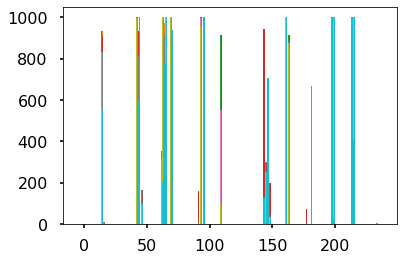

In [11]:
# Let's get uncertainty estimates by getting the hist for each one and taking the SEM
all_hist_y=[]
all_hist_x=[]

for i in range(len(all_residues_by_timestep)):
    subx=[]
    suby=[]
    for j in range(len(all_residues_by_timestep[i])):
        suby.append(hist(all_residues_by_timestep[i][j],bins = arange(-4.5,238.5,1))[0]/len(systems[i][j].trajectory))
        subx.append(hist(all_residues_by_timestep[i][j],bins = arange(-4.5,238.5,1)-.5)[1])
        #cla()
    all_hist_x.append(subx)
    all_hist_y.append(suby)
    
# Now average over them and also compute the sem

system_avg_hist_y = []
system_sem_hist_y = []

for i in range(len(all_hist_y)):
    system_avg_hist_y.append(mean(all_hist_y[i],axis = 0))
    system_sem_hist_y.append(scipy.stats.sem(all_hist_y[i],axis = 0))


Text(0.5, 1.0, 'Residue Contact Propensity Difference: PEG - H2O (significant only)')

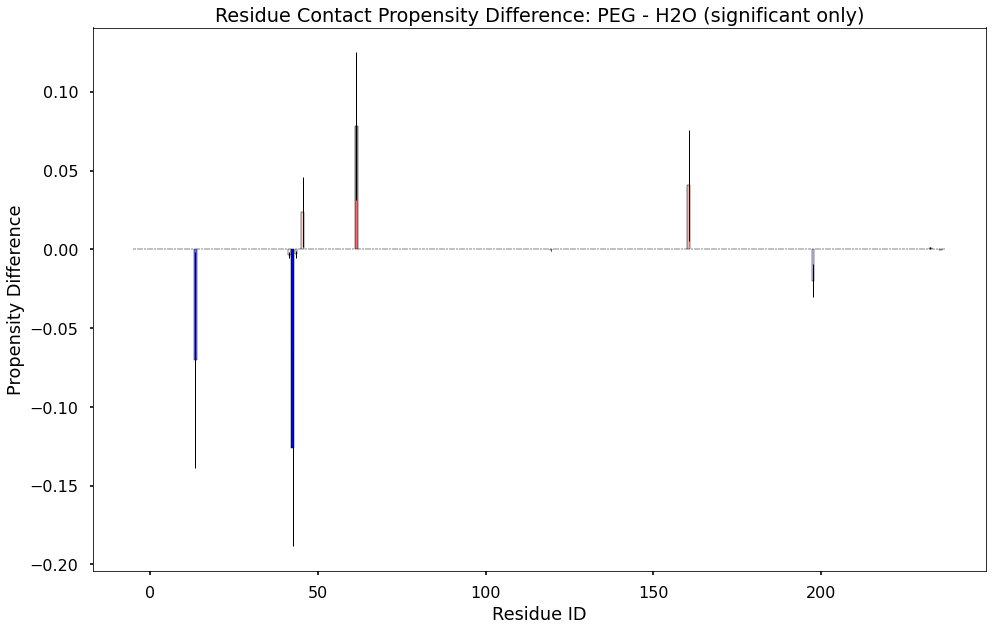

In [12]:
avgDiffBars = (system_avg_hist_y[1] - system_avg_hist_y[0])
semDiffBars = sqrt(system_sem_hist_y[1]**2 + system_sem_hist_y[0]**2)
colors =[]

for i in range(len(avgDiffBars)):
    if avgDiffBars[i] > 0:
        colors.append([1.,1-(avgDiffBars[i]/max(abs(avgDiffBars))),1-(avgDiffBars[i]/max(abs(avgDiffBars)))])
    if avgDiffBars[i] <=0:
        colors.append([1-(-avgDiffBars[i]/max(abs(avgDiffBars))),1-(-avgDiffBars[i]/max(abs(avgDiffBars))),1.])
        
# get significant only
avgSignifBars=copy(avgDiffBars)
semSignifBars=copy(semDiffBars)
for i in range(len(avgDiffBars)):
    
    if abs(semDiffBars[i]) > abs(avgDiffBars[i]):
        avgSignifBars[i] = 0
        semSignifBars[i] = 0        
        
figure(figsize = (16,10))

bar(all_hist_x[0][0][:-1]+.5,avgSignifBars,color = colors,edgecolor= 'black')
errorbar(all_hist_x[0][0][:-1]+.5,avgSignifBars,semSignifBars,fmt=".",markersize = 0.01,linewidth = 1, color = "black")
xlabel("Residue ID")
ylabel("Propensity Difference")
title("Residue Contact Propensity Difference: PEG - H2O (significant only)") 
